# Tugas 1 Machine Learning: Data Visualisation

- Nama: Faiz Unisa Jazadi
- NIM: 21/475298/PA/20563
- Kelas: KOMA
- Tanggal: 2023-02-24

## Soal

1.   Cari minimal 1 dataset terstruktur dan 1 dataset tidak terstruktur secara
     programatik menggunakan API atau web scraping, jelaskan langkah-langkahnya!
2.   Kemudian, lakukan eksplorasi:
     -   Visualisasi variabel untuk beberapa variabel/feature dengan variabel
        yang sesuai, dan
     -   Visualisasi statistik
   
## Jawaban

In [118]:
%pip install requests tabulate

import os
import itertools
import datetime

import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Data Terstruktur

Data yang dipilih untuk digunakan dalam tugas ini adalah data hasil penertiban minuman keras Satpol PP Jakarta Utara tahun 2017. Data diperoleh melalui API yang didapat dari layanan [Open Data Jakarta](https://data.jakarta.go.id).

#### Akuisisi Data

In [76]:
import requests

data = requests.get('https://data.jakarta.go.id/read-resource/get-json/data-hasil-penertiban-minuman-keras-satpol-pp-jakarta-utara/2a1632ad-fe5d-477c-95b9-9d2ba0efa7e9').json()
df = pd.DataFrame.from_dict(data)
df.head()

wilayah     jenis_minuman  jumlah volume
0  Kecamatan Pademangan               Ciu      19  Botol
1  Kecamatan Pademangan  Anggur Orang Tua     134  Botol
2  Kecamatan Pademangan           Guinnes      12  Botol
3  Kecamatan Pademangan      Anggur Merah      84  Botol
4  Kecamatan Pademangan          Rajawali      84  Botol

#### Visualisasi Data

<AxesSubplot: ylabel='wilayah'>

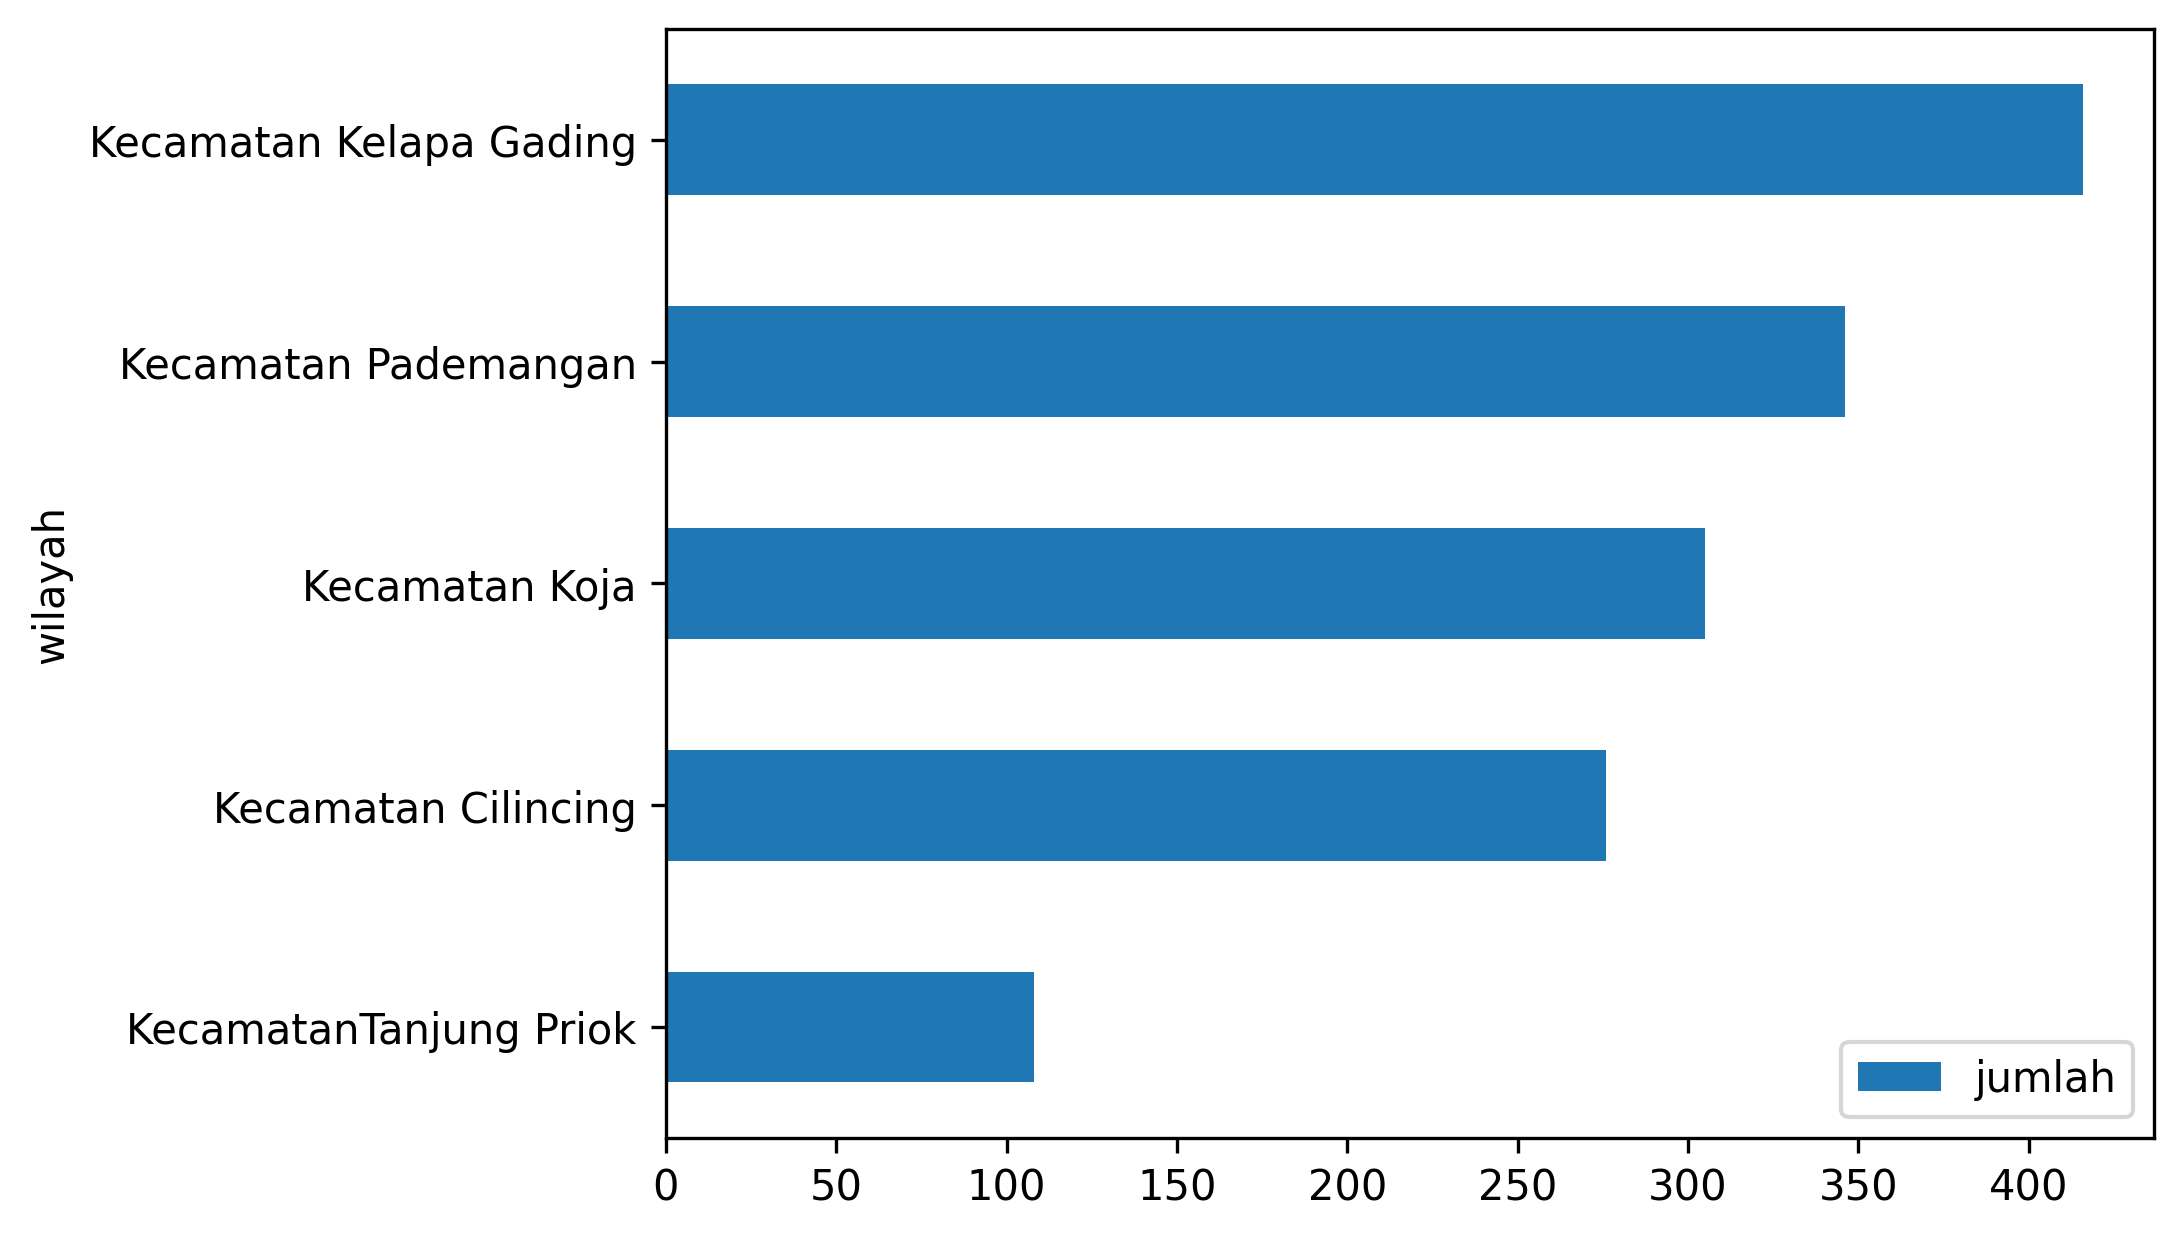

In [8]:
df.describe()
df.groupby(by='wilayah').sum().sort_values(
    'jumlah').plot(kind='barh')

In [34]:
df.groupby('jenis_minuman').sum().sort_values(
    'jumlah').plot.pie(y='jumlah', legend=None, autopct='%1.1f%%')

<AxesSubplot: ylabel='jumlah'>

### Data Tidak Terstruktur

#### Akuisisi Data

In [111]:
!mkdir sat_data

def generate_timecodes():
    timecodes = map(lambda t: f'{t[0]:02}{t[1]:02}',
                    itertools.product(range(24), range(0, 60, 10)))
    for t in timecodes:
        if t in ('0240', '1440'):
            continue
        yield t

sat_url = 'https://www.data.jma.go.jp/mscweb/data/himawari/img/se3/se3_b07_{}.jpg'
timecodes = generate_timecodes()
for timecode in timecodes:
    if os.path.exists(f'sat_data/{timecode}.jpg'):
        print('data already collected, clean sat_data to start over')
        break
    r = requests.get(sat_url.format(timecode))
    with open(f'sat_data/{timecode}.jpg', 'wb') as f:
        f.write(r.content)
    print(f'collected sat image: {timecode}')

!rm sat_data/0240.jpg sat_data/1440.jpg

mkdir: cannot create directory ‘sat_data’: File exists
data already collected, clean sat_data to start over
rm: cannot remove 'sat_data/0240.jpg': No such file or directory
rm: cannot remove 'sat_data/1440.jpg': No such file or directory


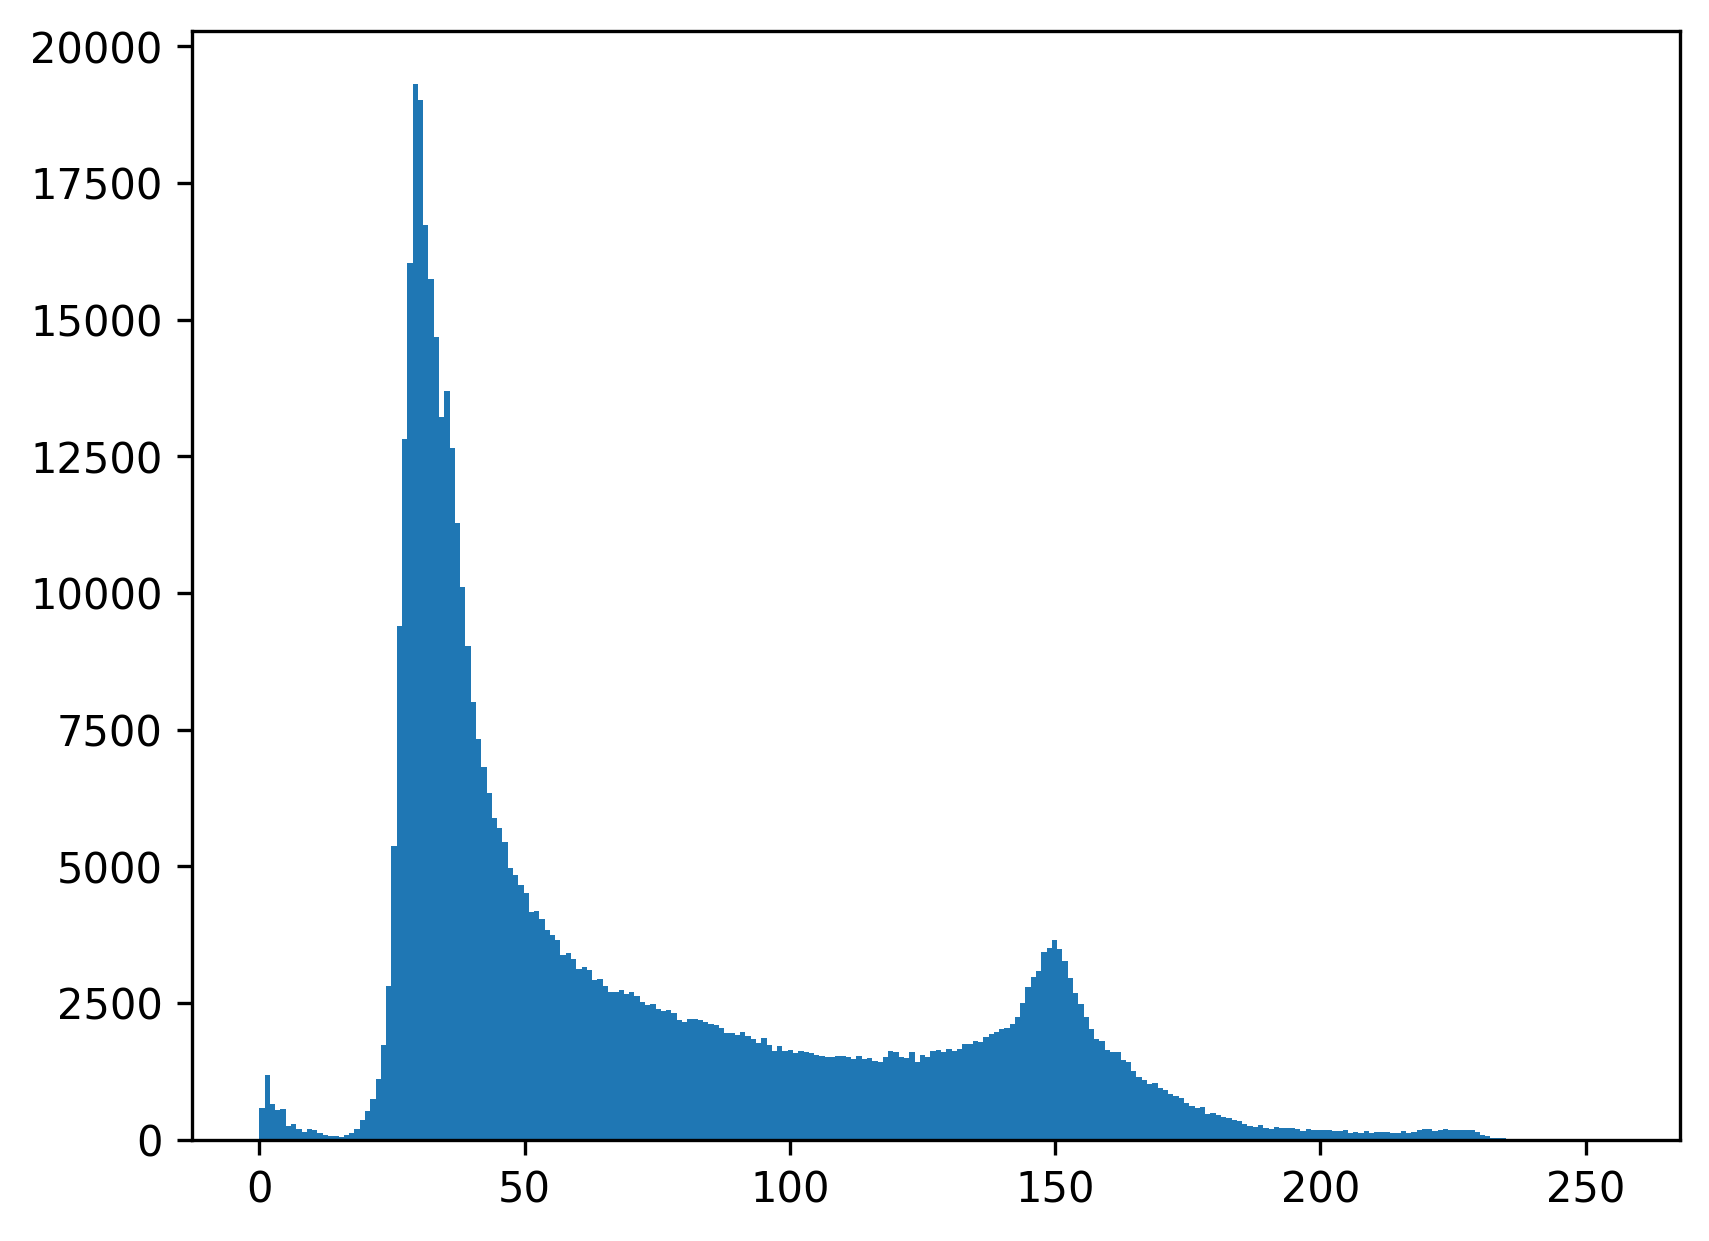

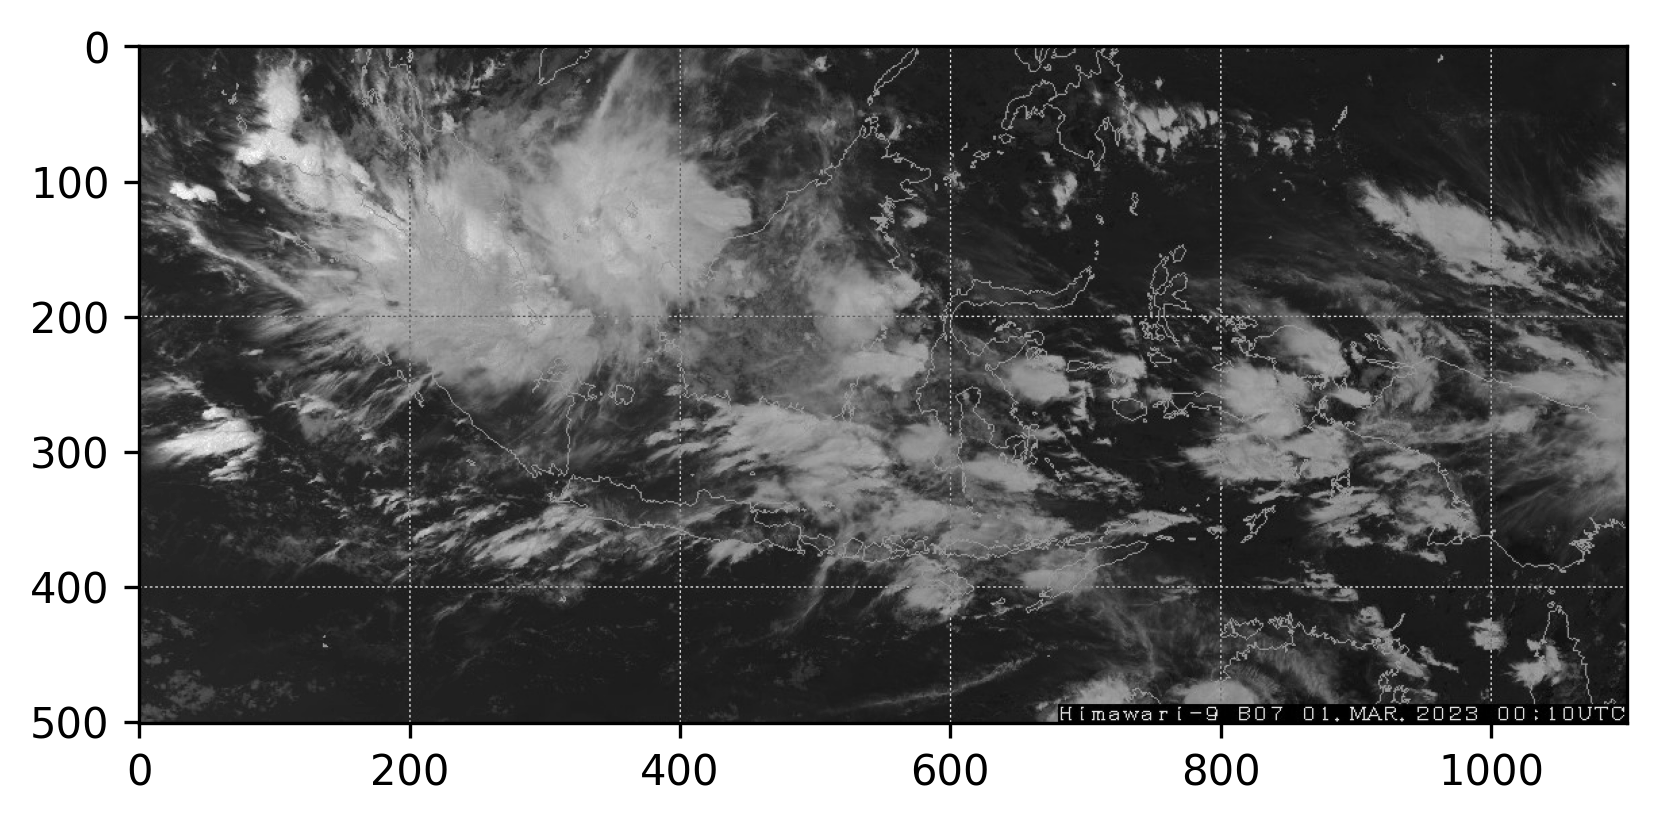

In [92]:
def show_image(im):
    plt.imshow(im, cmap='gray')
    plt.show()

sample_im = cv2.imread('sat_data/0000.jpg')
sample_im = cv2.cvtColor(sample_im, cv2.COLOR_BGR2GRAY)

plt.hist(sample_im.ravel(), bins=256)
plt.show()

show_image(sample_im)

#### Thresholding

In [94]:
def calc_cloudiness(im_path):
    im = cv2.imread(im_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    _, t_im = cv2.threshold(im, 120, 255, cv2.THRESH_BINARY)
    freq, _ = np.histogram(t_im.ravel(), bins=2)
    return freq[1] / np.sum(freq)

#### Feature Extraction

Time and cloudiness

In [135]:
def timecode_to_dt(t, offset):
    h = int(t[:2])
    m = int(t[2:])
    s = datetime.datetime.strptime(offset, '%Y-%m-%d')
    return s + datetime.timedelta(hours=h, minutes=m)

reordered_timecodes = list(generate_timecodes())
split_i = reordered_timecodes.index('0930')
reordered_timecodes = (reordered_timecodes[split_i:] 
                       + reordered_timecodes[:split_i])
    
data = []
    
for t in reordered_timecodes:
    im_path = f'sat_data/{t}.jpg'
    data.append({
        'time': timecode_to_dt(t, '2023-02-28'),
        'cloudiness': calc_cloudiness(im_path),
    })

df = pd.DataFrame.from_dict(data)
print(df.head().to_markdown())

|    | time                |   cloudiness |
|---:|:--------------------|-------------:|
|  0 | 2023-02-28 09:30:00 |     0.144469 |
|  1 | 2023-02-28 09:40:00 |     0.151086 |
|  2 | 2023-02-28 09:50:00 |     0.159581 |
|  3 | 2023-02-28 10:00:00 |     0.169581 |
|  4 | 2023-02-28 10:10:00 |     0.181477 |


<AxesSubplot: xlabel='time'>

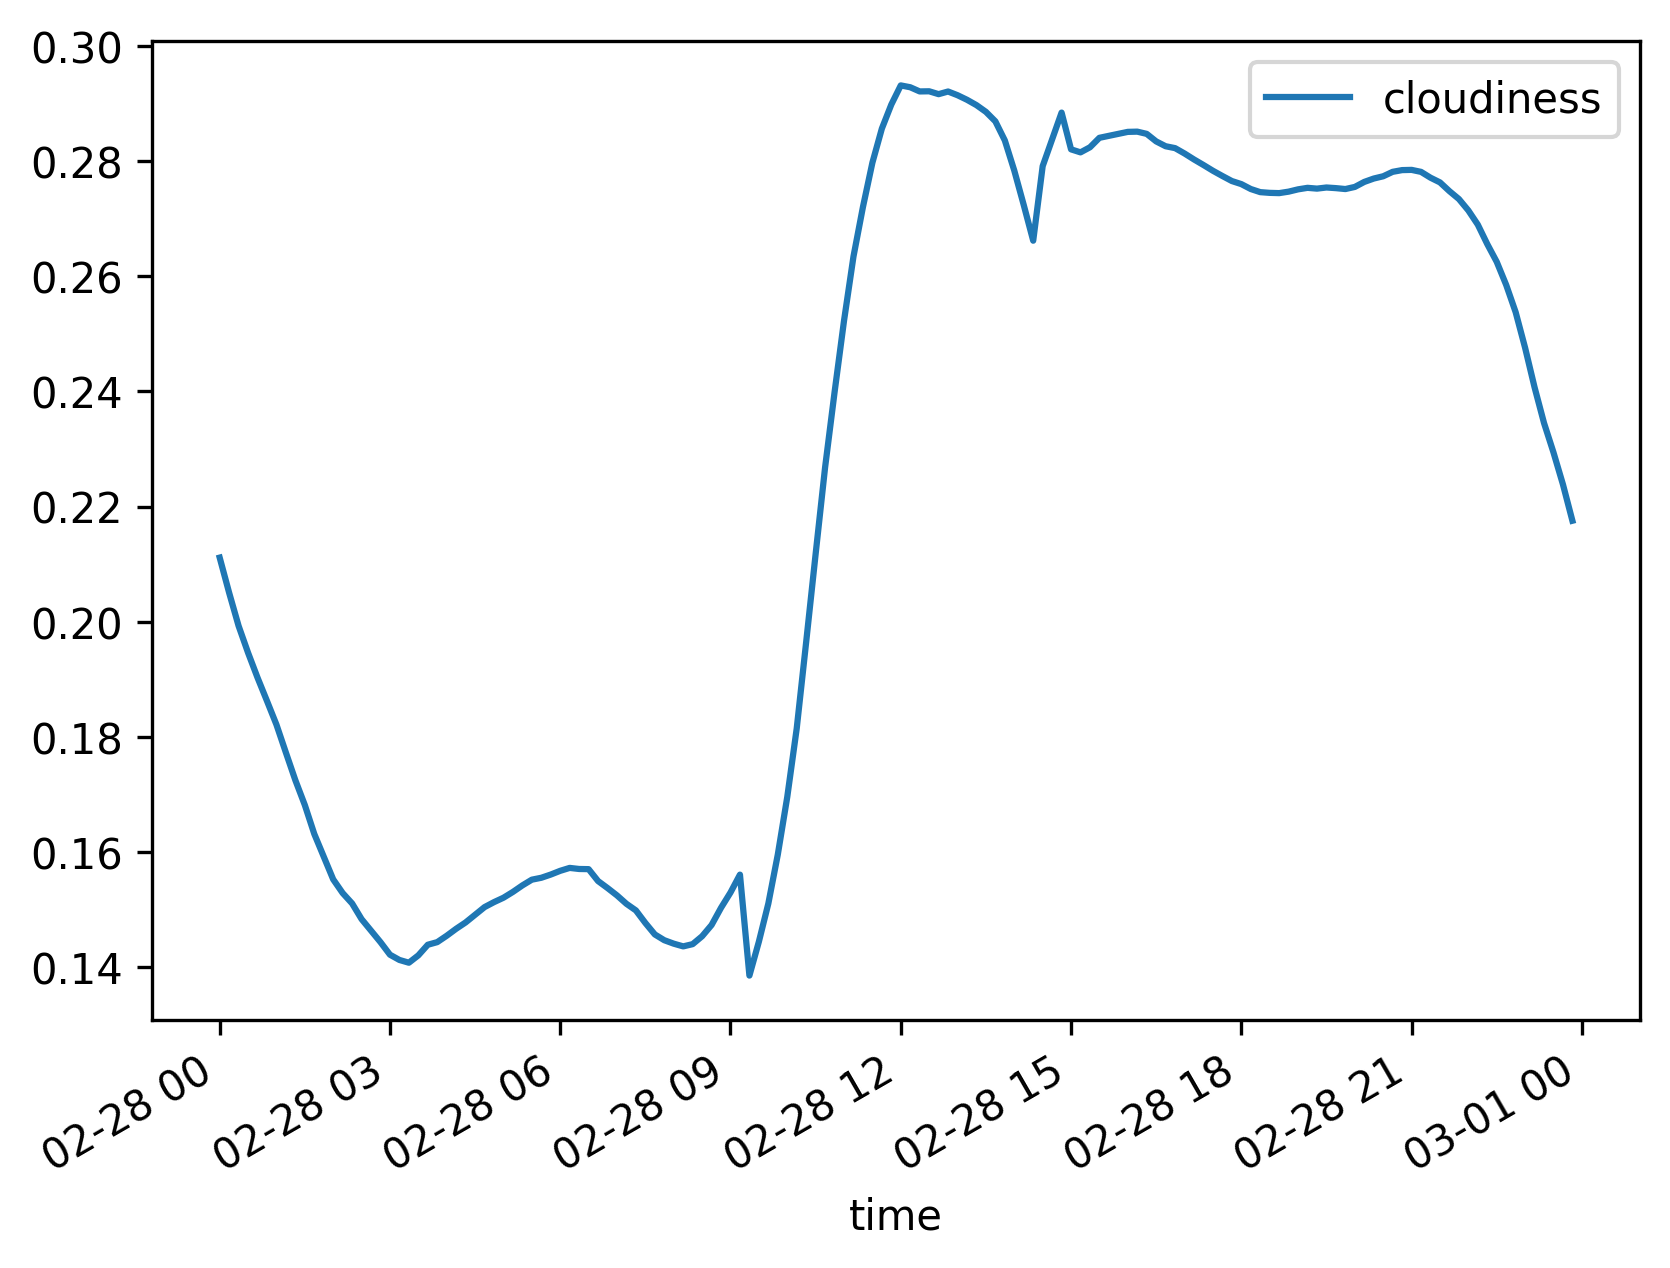

In [139]:
df.plot(kind='line', x='time', y='cloudiness')

In [133]:
print(df.describe().to_markdown())

|       |   cloudiness |
|:------|-------------:|
| count |  142         |
| mean  |    0.222873  |
| std   |    0.0600493 |
| min   |    0.138577  |
| 25%   |    0.154424  |
| 50%   |    0.249913  |
| 75%   |    0.278256  |
| max   |    0.293119  |
